# Using Fast-Higashi to integrate two Dip-C Tan et al. Cell mousebrain dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fasthigashi.FastHigashi_Wrapper import *
# Set the path to the configuration file, change it accordingly
# The format of the config file is the same as the Higashi config JSON
config = "/home/rzhang/fast_higashi_git/config_dir/config_dipc_Tan_mousebrain_joint_500k.JSON"

In [3]:
# initialize the model
wrapper = FastHigashi(config_path=config,
                      path2input_cache=None, # when setting at None, will use the temp_dir on the JSON file
                      path2result_dir=None, # same as above
                      off_diag=100,
                      filter=True,
                      do_conv=False, # at coarser resolution for high cov data, recommend to be False
                      do_rwr=True, # let's do partial rwr~
                      do_col=False,
                      no_col=False)


setting to gpu:5


In [4]:
# From contact pairs to the sparse matrices and store them on disk
if not os.path.exists(os.path.join(wrapper.temp_dir, "raw", "%s_sparse_adj.npy" % wrapper.chrom_list[0])):
    start = time.time()
    wrapper.fast_process_data()
    print("contact pairs to sparse mtx takes: %.2f s" % (time.time() - start))


generating start/end dict for chromosome
extracting from filelist.txt


  0%|          | 0/3646 [00:00<?, ?it/s]

fast process finishes
contact pairs to sparse mtx takes: 122.20 s


In [5]:
# packing data from sparse matrices to sparse tensors
start = time.time()
wrapper.prep_dataset(batch_norm=False) # we don't have batch_id provided so, set as False
print("packing sparse mtx takes: %.2f s" % (time.time() - start))

total number of cells that pass qc check 3645 bad 1 total: 3646
cache file = /home/rzhang/Higashi/Temp/dipc_mouse_two_tissue/cache_intra_500000_offdiag_100_.pkl


packing sparse mtx into sparse tensors:   0%|          | 0/19 [00:00<?, ?it/s]

Sorting indices in sparse tensors:   0%|          | 0/19 [00:00<?, ?it/s]

saving cached input to /home/rzhang/Higashi/Temp/dipc_mouse_two_tissue/cache_intra_500000_offdiag_100_.pkl
gpu mem
c_nvmlMemory_t(total: 25757220864 B, free: 25430523904 B, used: 326696960 B)
sparsity 0.04567744811491387
do_conv False do_rwr True do_col False
recommend_bs_cell [3645, 3645, 3645, 3645, 3645, 3645, 3645, 3645, 3645, 3645, 3645, 3645, 3645, 3645, 3645, 3645, 3645, 3645, 3645] pinning memory
packing sparse mtx takes: 50.50 s


In [6]:

wrapper.run_model(extra="", # can be any words, this will be appended to the model name when the model is saved. Used as an identifier.
                  rank=256,
                  n_iter_parafac=1,
                  tol=3e-4, # on this dataset tol=3e-4 leads to good enough results, but you can run it further with tol=2e-5 or smaller. It's suggested to inspect in the middle training point (See more in the FastHigashi_dipc_Tan_mousebrain_500k.ipynb)
                  )

# loading existing trained models
# This operation is optional when the model is just trained
wrapper.load_model(extra="",
                   rank=256,
                   n_iter_parafac=1
                   )

dim1_0.6_rank_256_niterp_1_
n_iter_parafac 1
time elapsed: 0.01


initializing params:   0%|          | 0/19 [00:00<?, ?it/s]

rwr iters: [6 6 6 6 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
time elapsed: 22.80
finish init
Starting iteration 0

PARAFAC2 re=5.940 takes 8.0s
Starting iteration 1

PARAFAC2 re=0.361 9.96e-01 variation min9.9e-01 at chrom 18, max1.0e+00 at chrom 0 takes 8.0s
Starting iteration 2

PARAFAC2 re=0.345 8.83e-02 variation min6.6e-02 at chrom 9, max9.9e-02 at chrom 14 takes 8.2s
Starting iteration 3

PARAFAC2 re=0.336 4.98e-02 variation min3.9e-02 at chrom 10, max6.5e-02 at chrom 9 takes 8.2s
Starting iteration 4

PARAFAC2 re=0.334 1.29e-02 variation min1.1e-02 at chrom 10, max1.9e-02 at chrom 9 takes 8.1s
Starting iteration 5

PARAFAC2 re=0.333 5.18e-03 variation min3.7e-03 at chrom 10, max8.7e-03 at chrom 6 takes 8.2s
Starting iteration 6

PARAFAC2 re=0.333 2.80e-03 variation min1.6e-03 at chrom 18, max4.8e-03 at chrom 6 takes 8.1s
Starting iteration 7

PARAFAC2 re=0.332 1.75e-03 variation min7.9e-04 at chrom 18, max2.9e-03 at chrom 6 takes 8.1s
Starting iteration 8

PARAFAC2 re=0.332 1.19e-03 varia

In [7]:
# getting embedding
embed = wrapper.fetch_cell_embedding(final_dim=64, # Because we have a small number of cells here, smaller dim leads to more continuous trajectories while larger dim leads to more separated cluste patterns, will run with 256 later.
                                     restore_order=False)
print (wrapper.label_info.columns)
# regress out experiments related bias
wrapper.correct_batch_linear('exp')
# The returned embed is a dictionary that stores the embeddings after different ways of post-processing.
# 'embed_l2_norm' or 'embed_l2_norm_correct_coverage_fh' usually yields the best results, the latter one represents linear correction of sequencing depth bias.
print (embed.keys())

# You see there's now two additional key called 'embed_l2_norm_correct_exp' and 'embed_corerct_exp'? They correspond to the experiment condition corrected embeddings w / wo l2 normalization

Index(['level_0', 'index', 'cell', 'tissue', 'treatment', 'age', 'sex',
       'father', 'mother', 'restriction enzyme', 'cell-type cluster', 'reads',
       'read length (bp)', 'raw throughput (Gb)', 'raw contacts',
       'raw intra (%)', 'dup rate (%)', 'contacts', 'intra (%)',
       'phased legs (%)', 'raw contacts per read (%)', '20kb RMS RMSD',
       'new age', 'exp', 'coverage_fh'],
      dtype='object')
dict_keys(['embed_all', 'embed_raw', 'embed_l2_norm', 'restore_order', 'embed_correct_coverage_fh', 'embed_l2_norm_correct_coverage_fh', 'embed_correct_exp', 'embed_l2_norm_correct_exp'])


Index(['level_0', 'index', 'cell', 'tissue', 'treatment', 'age', 'sex',
       'father', 'mother', 'restriction enzyme', 'cell-type cluster', 'reads',
       'read length (bp)', 'raw throughput (Gb)', 'raw contacts',
       'raw intra (%)', 'dup rate (%)', 'contacts', 'intra (%)',
       'phased legs (%)', 'raw contacts per read (%)', '20kb RMS RMSD',
       'new age', 'exp', 'coverage_fh'],
      dtype='object')


2022-11-28 20:46:21.836469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


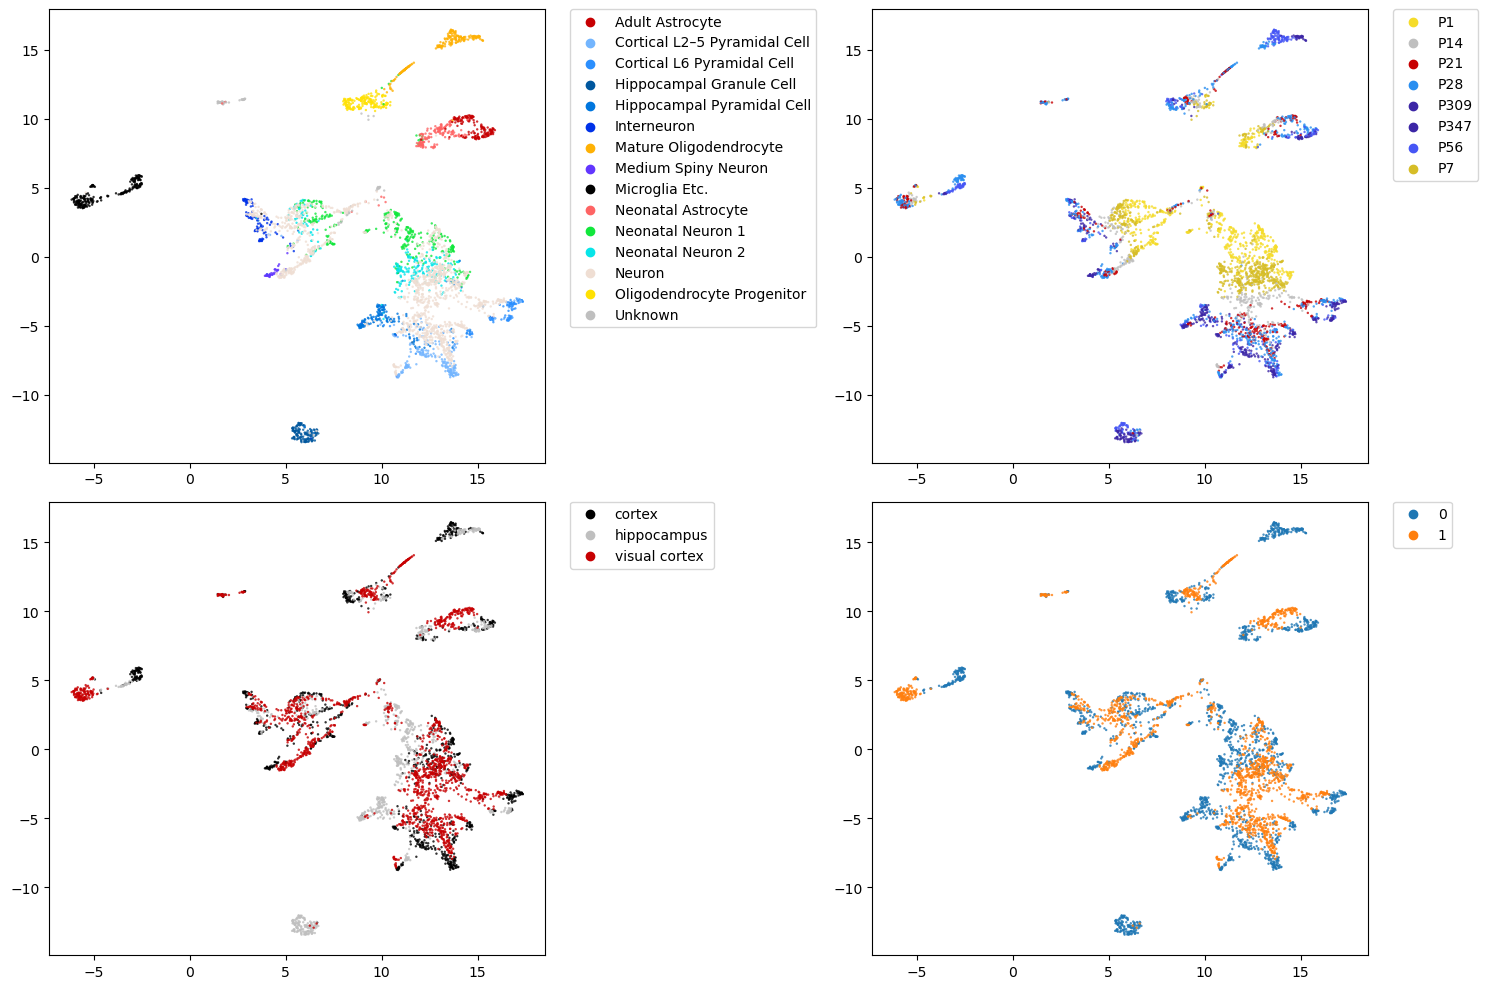

In [8]:
# Check available label information
print (wrapper.label_info.columns)
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

embedding = embed['embed_correct_exp']
vec = UMAP(n_components=2, n_neighbors=15, min_dist=0.3,  random_state=0).fit_transform(embedding)
# pull the visualization palette from the config file
vis_palette = wrapper.config['vis_palette']


fig = plt.figure(figsize=(15, 10))
for col_index, col in enumerate(["cell-type cluster", "age", "tissue", "exp"]):
    ax = plt.subplot(2, 2, col_index + 1)
    try:
        pal = vis_palette[col]
    except:
        pal = None
    sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=wrapper.label_info[col], ax=ax, s=3, alpha=0.8, linewidth=0, palette=pal, hue_order=np.unique(wrapper.label_info[col]))
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.tight_layout()
plt.show()




Index(['level_0', 'index', 'cell', 'tissue', 'treatment', 'age', 'sex',
       'father', 'mother', 'restriction enzyme', 'cell-type cluster', 'reads',
       'read length (bp)', 'raw throughput (Gb)', 'raw contacts',
       'raw intra (%)', 'dup rate (%)', 'contacts', 'intra (%)',
       'phased legs (%)', 'raw contacts per read (%)', '20kb RMS RMSD',
       'new age', 'exp', 'coverage_fh'],
      dtype='object')


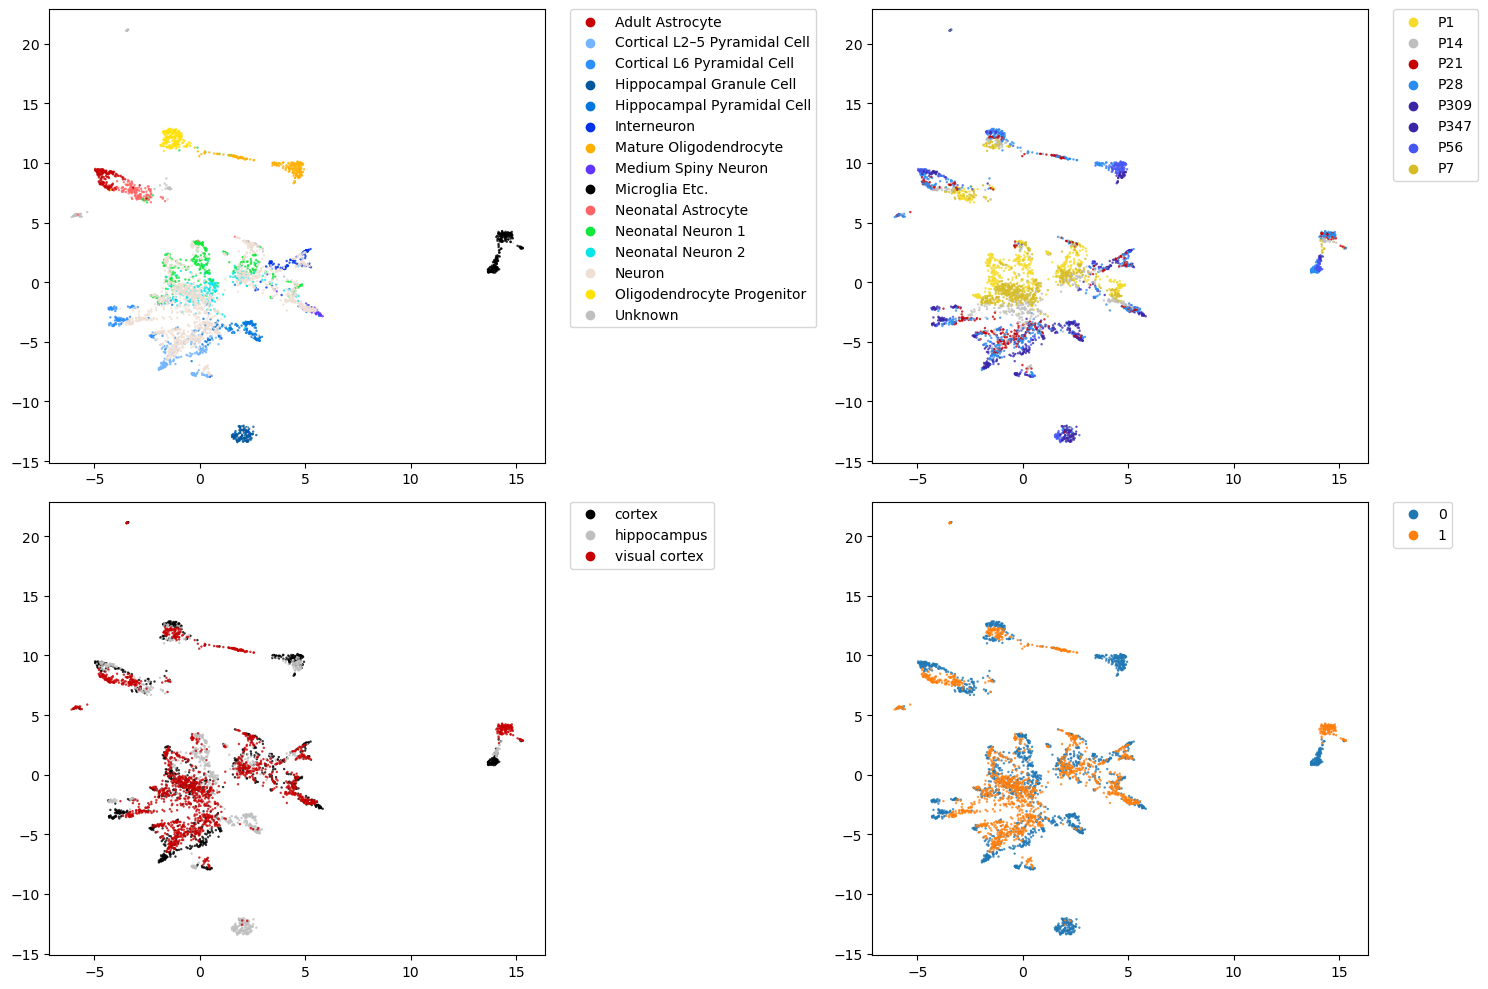

In [9]:
# getting embedding
embed = wrapper.fetch_cell_embedding(final_dim=256, # Run with 256 this time.
                                     restore_order=False)
print (wrapper.label_info.columns)
# regress out experiments related bias
wrapper.correct_batch_linear('exp')

embedding = embed['embed_correct_exp']
vec = UMAP(n_components=2, n_neighbors=15, min_dist=0.3,  random_state=0).fit_transform(embedding)
# pull the visualization palette from the config file
vis_palette = wrapper.config['vis_palette']


fig = plt.figure(figsize=(15, 10))
for col_index, col in enumerate(["cell-type cluster", "age", "tissue", "exp"]):
    ax = plt.subplot(2, 2, col_index + 1)
    try:
        pal = vis_palette[col]
    except:
        pal = None
    sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=wrapper.label_info[col], ax=ax, s=3, alpha=0.8, linewidth=0, palette=pal, hue_order=np.unique(wrapper.label_info[col]))
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.tight_layout()
plt.show()

# The patterns are consistent, just cells are more clustered.
